In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv
/kaggle/input/customer-personality-analysis/marketing_campaign.csv


data source: fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

With visualization, I used this notebook's code: https://www.kaggle.com/ludovicocuoghi/plotly-viz-pytorch-neural-net-f1-94-auc-92

In [2]:
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv", skipinitialspace=True)

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve, accuracy_score

In [5]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
# check missing data
df.isnull().sum() # no missing! yeah

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [8]:
# duplicated ? 
df[df.duplicated()] # no duplicated values

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


In [9]:
# dim
df.shape # n=918, p=12. not that big n. 

(918, 12)

**Visualization**

In [10]:
px.histogram(df, x="Age", color="HeartDisease", marginal="box")

In [11]:
# automization
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
def num_plot(df, col):
    fig = px.histogram(df, x=col, color='HeartDisease', marginal='box')
    fig.update_layout(height=400, width=500, showlegend=True)
    fig.update_traces(marker_line_width=1, marker_line_color='black')
    fig.show()
    

In [12]:
for col in num_cols:
    num_plot(df, col)

a lot of patients' cholesterol is zero. 

In [13]:
df_zeroch = df[df['Cholesterol']==0]

In [14]:
for col in num_cols:
    num_plot(df_zeroch, col)

In [15]:
df_ch = df[df['Cholesterol']>0]

In [16]:
for col in num_cols:
    num_plot(df_ch, col)

Is it rational to have zero cholesterol? not sure about this point. 
thus I decided to drop cholesterol variable in analyzing. 

In [17]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [18]:
df1=df.drop('Cholesterol', axis=1)

It seems that there exists outlier in Resting BP ( zero) 

In [19]:
df1[df1['RestingBP']==0]

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,Normal,155,N,1.5,Flat,1


{'whiskers': [<matplotlib.lines.Line2D at 0x7efe251a2c10>,
 'caps': [<matplotlib.lines.Line2D at 0x7efe1d12f450>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efe251a27d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7efe1d12fd10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7efe1d138190>],
 'means': []}

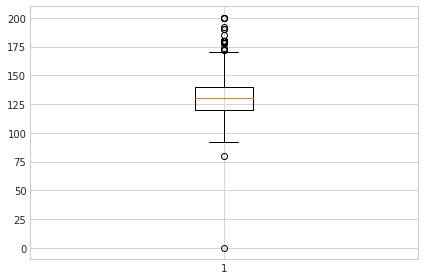

In [20]:
plt.boxplot(df1['RestingBP'])

RestingBP is resting blood pressure, and it is nonsense to have zero blood pressure. Thus I decided to delete #449 obs.

In [21]:
df2 = df1.drop([449])

In [22]:
df2.iloc[447:450] # well dropped.

,Age,Sex,ChestPainType,RestingBP,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
447,77,M,ASY,124,0,ST,110,Y,2.0,Up,1
448,63,M,ASY,160,1,Normal,105,Y,1.0,Flat,1
450,52,M,NAP,122,0,Normal,110,Y,2.0,Down,1


**Preprocessing**
* Gender: Male=0, Female=1

In [23]:
df2.Sex = df2.Sex.replace({'M':0, 'F':1})

In [24]:
df2.ChestPainType.value_counts()  # similar with table in R
# latter, planning to use dummy coding (one hot encoding)

ASY    496
NAP    202
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [25]:
df2.RestingECG.value_counts() # use dummy coding 

Normal    551
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [26]:
df2.ExerciseAngina = df2.ExerciseAngina.replace({'Y':1, 'N':0})

In [27]:
df2.ST_Slope.value_counts() # use dummy coding

Flat    459
Up      395
Down     63
Name: ST_Slope, dtype: int64

In [28]:
df2.HeartDisease.value_counts() # target

1    507
0    410
Name: HeartDisease, dtype: int64

Target variable is quite well-balanced, and it is binary. In this notebook, classification methods would be used to predict heart failure.

In [29]:
df3 = shuffle(df2)

In [30]:
encdf = pd.get_dummies(df3, drop_first=True)

In [31]:
encdf # shuffled & create dummy variables

,Age,Sex,RestingBP,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
578,57,0,156,0,119,1,3.0,1,0,0,0,0,0,0,0
562,59,0,140,0,154,1,2.0,0,0,0,0,1,0,1,0
601,61,0,140,0,123,1,1.3,1,0,1,0,1,0,1,0
418,60,0,132,0,140,1,1.5,1,0,0,0,0,1,0,0
2,37,0,130,0,98,0,0.0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,40,0,106,0,80,1,0.0,0,0,1,0,1,0,0,1
146,42,0,120,0,155,0,0.0,0,1,0,0,1,0,0,1
450,52,0,122,0,110,1,2.0,1,0,1,0,1,0,0,0
210,48,0,106,1,110,0,0.0,1,0,0,0,1,0,1,0


In [32]:
X = encdf.drop('HeartDisease', axis=1).values

In [33]:
y = encdf['HeartDisease'].values # make x and y as arrays

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [35]:
# standardize 
# fit & transform : https://www.inflearn.com/questions/19038 

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

methods introduced in *Introduction to Statistical Learning(2nd ed) are used. (ch5, 6, 7)

* Logistic Regression and LDA showed good result, 
* so I would try cross-validation with those two methods. ( to see whether accuracy scores are stable )

In [36]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [37]:
def get_scores(y, y_pred):
    data={'Accuracy': np.round(accuracy_score(y, y_pred),2),
    'Precision':np.round(precision_score(y, y_pred),2),
    'Recall':np.round(recall_score(y, y_pred),2),
    'F1':np.round(f1_score(y, y_pred),2),
    'ROC AUC':np.round(roc_auc_score(y, y_pred),2)}
    scores_df = pd.Series(data).to_frame(' ').transpose()
    return scores_df

In [38]:
model1 = LogisticRegression()

In [39]:
pred = cross_val_predict(model1, X_train, y_train, cv=5)

In [40]:
get_scores(y_train, pred)

,Accuracy,Precision,Recall,F1,ROC AUC
,0.84,0.85,0.87,0.86,0.84


In [41]:
model2 = LinearDiscriminantAnalysis()
pred2 = cross_val_predict(model2, X_train, y_train, cv=5)
get_scores(y_train, pred2)

,Accuracy,Precision,Recall,F1,ROC AUC
,0.84,0.85,0.87,0.86,0.84


Seems that model1(LR) works better! 
Although I have the test dataset now, in real life, there is no test data. So I really have to check with this. 

**Nonlinear modeling** 
- Generalized additive model: allows for flexible non-linearities & retains the additive structure of linear models. 
- can be also expanded for classifications. 
- R